# Random Forest

In [89]:
# Importing modules
import pandas as pd
import numpy as np
%matplotlib inline

# Load the cleaned data with DEP_DELAY included
df_cleaned = pd.read_csv("../cleaning-preprocessing/cleaned_flight_data_with_target.csv")

#Separating Features
X = df_cleaned.drop(columns=['DEP_DELAY'])  
y = df_cleaned['DEP_DELAY']

In [90]:
from sklearn.model_selection import train_test_split

# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}")
print(f"Testing size: {X_test.shape}")

Training size: (23056, 110)
Testing size: (5764, 110)


Random Forest Model Test Accuracy: 0.8707
F1 Score: 0.2215

Classification Report Pure Training:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93      4950
           1       0.74      0.13      0.22       814

    accuracy                           0.87      5764
   macro avg       0.81      0.56      0.58      5764
weighted avg       0.86      0.87      0.83      5764



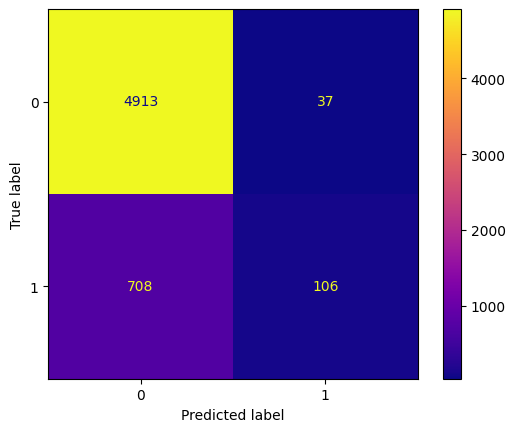

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train the Random Forest model using the resampled training set
rf_model = RandomForestClassifier(n_estimators=100, random_state=156, max_features=10, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions on the original test set
preds_test = rf_model.predict(X_test)

# Print accuracy and F1-score
print(f'Random Forest Model Test Accuracy: {accuracy_score(y_test, preds_test):.4f}')
print(f'F1 Score: {f1_score(y_test, preds_test):.4f}')
print("\nClassification Report Pure Training:\n", classification_report(y_test, preds_test))

# Compute and display the confusion matrix
matrix = confusion_matrix(y_test, preds_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap="plasma")  # You can change colormap to your preference

## Hyperparameter Tuning

In [100]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

# Define base RandomForest model
clf = RandomForestClassifier(random_state=156, class_weight='balanced')

# Define hyperparameter grid with more exhaustive search space
params = {
    'n_estimators': np.arange(100, 1001, 100),  # 100 to 1000 in steps of 100
    'max_depth': [10, 20, 30, 40, 50, 60, None],  
    'min_samples_split': np.arange(2, 21, 2),  # 2 to 20
    'min_samples_leaf': np.arange(1, 11, 1),  # 1 to 10
    'max_features': ['sqrt', 'log2', None],  
    'bootstrap': [True, False],
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=params, 
    n_iter=100,  # More iterations for a deeper search
    cv=5,  # More folds for better evaluation
    n_jobs=-1,  # Use all CPU cores
    verbose=2,  # Show progress
    scoring='f1', 
    return_train_score=True,
    random_state=156
)

# Fit the model (this may take an hour+)
random_search.fit(X_train, y_train)

# Get the best estimator and show parameters
print("Best hyperparameters:", random_search.best_params_)

# Evaluate the tuned model
clf_best = random_search.best_estimator_
y_test_pred = clf_best.predict(X_test)

# Print evaluation metrics
print('Hyperparameter tuning of random forest yields test accuracy:', accuracy_score(y_test, y_test_pred))
print('F1 Score:', f1_score(y_test, y_test_pred))
print('Precision:', precision_score(y_test, y_test_pred))
print('Recall:', recall_score(y_test, y_test_pred))

# Print Classification Report
print("\nClassification Report Hyperparam Tuning:\n", classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.feature_selection import RFE

selector = RFE(RandomForestClassifier(random_state=156), n_features_to_select=10, step=1)
selector.fit(X_train, y_train)

# List of selected features
selected_features = X_train.columns[selector.support_]
print("Selected features:", X_train.columns[selector.support_])

Selected features: Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'CRS_DEP_M', 'CRS_ARR_M', 'Temperature', 'Dew Point', 'Humidity',
       'Wind Speed', 'Wind Gust', 'Pressure', 'sch_dep',
       'OP_UNIQUE_CARRIER_B6'],
      dtype='object')


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=156)

# Train Random Forest model
new_rf = RandomForestClassifier(n_estimators=100, random_state=156, max_features=10)
new_rf.fit(X_train, y_train)

# Testing model
new_preds_test = new_rf.predict(X_test)

# Accuracy and F1 Score
print('Random forest model yields test accuracy:', accuracy_score(y_test, new_preds_test))
print('F1 Score:', f1_score(y_test, new_preds_test))
print("\nClassification Report RFE:\n", classification_report(y_test, y_test_pred))

Random forest model yields test accuracy: 0.8962526023594726
F1 Score: 0.4573502722323049

Classification Report RFE:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      4979
           1       0.14      0.25      0.18       785

    accuracy                           0.69      5764
   macro avg       0.50      0.51      0.50      5764
weighted avg       0.77      0.69      0.73      5764



Random Forest Model Test Accuracy (Class 1 Only): 0.3210
F1 Score: 0.4860

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.32      0.49       785

    accuracy                           0.32       785
   macro avg       0.50      0.16      0.24       785
weighted avg       1.00      0.32      0.49       785



C:\Users\Cole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Cole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: Undefin

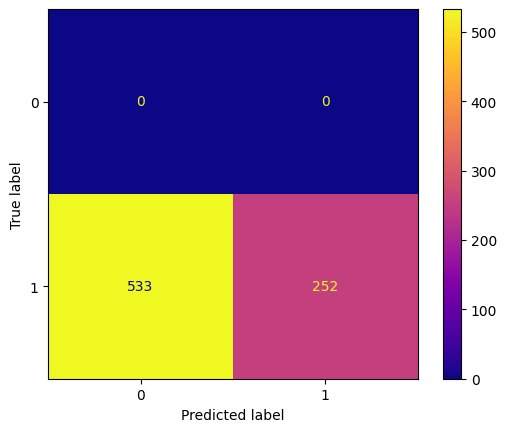

In [95]:
# Filter X_test and y_test to only include instances where y_test is 1
X_test_filtered = X_test[y_test == 1]  # Select only the rows where y_test is 1
y_test_filtered = y_test[y_test == 1]  # Keep only the corresponding labels

# Make predictions using the filtered test set
preds_filtered = new_rf.predict(X_test_filtered)

# Print accuracy and F1-score for the filtered set
print(f'Random Forest Model Test Accuracy (Class 1 Only): {accuracy_score(y_test_filtered, preds_filtered):.4f}')
print(f'F1 Score: {f1_score(y_test_filtered, preds_filtered):.4f}')
print("\nClassification Report:\n", classification_report(y_test_filtered, preds_filtered))

# Compute and display the confusion matrix
matrix_filtered = confusion_matrix(y_test_filtered, preds_filtered)
disp_filtered = ConfusionMatrixDisplay(confusion_matrix=matrix_filtered)
disp_filtered.plot(cmap="plasma")  # Adjust colormap to match your preference